In [1]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src/models/")
from swin import BaseSwinUnet
from restormer import BaseRestormer
from bunet import BaseUnet
from noiseadding import build_noise_transforms, CombinedTransforms
from data import get_train_val_dataset, get_dataset, get_train_val_dataset
from metrics import ConfusionMatrix, RMSE
import torchvision
from numba import cuda

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def build_model(model, problem):
    if model == 'restormer':
        if problem == 'deraining':
            model = BaseRestormer(inp_channels=3, out_channels=3, dim=24)
        elif problem == 'denoise':
            model = BaseRestormer(inp_channels=1, out_channels=1, dim=24, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseRestormer(inp_channels=1, out_channels=2, dim=24)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'swin':
        if problem == 'deraining':
            model = BaseSwinUnet(in_chans=3, num_classes=3, embed_dim=48)
        elif problem == 'denoise':
            model = BaseSwinUnet(in_chans=1, num_classes=1, embed_dim=48, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseSwinUnet(in_chans=1, num_classes=2, embed_dim=48)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'unet':
        if problem == 'deraining':
            model = BaseUnet(in_channels=3, out_channels=3)
        elif problem == 'denoise':
            model = BaseUnet(in_channels=1, out_channels=1, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseUnet(in_channels=1, out_channels=2)
        else:
            raise ValueError('Undefined problem!')
    else:
        raise ValueError('Undefined model!')
    return model

In [21]:
model_type='unet'
problem='firstbreak'
if problem == 'firstbreak':
    metrics = ConfusionMatrix(2, ["empty", "firstbreak"])
else:
    metrics = RMSE()
noise_type = -1
noise_scale = 0.0
batch_size=8
workers=4
METADATA = '../metadata/'

In [42]:
model = build_model(model_type, problem)
device = torch.device("cpu")
model.to(device)
weight_file = 'unet_denoise_noisetype_-1_noisescale_0.0'
save_path = os.path.join(METADATA, weight_file + '.pkl')
# model.load_state_dict(torch.load(save_path))
# model.eval()
model.unet.encoder1[0].weight

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Parameter containing:
tensor([[[[ 0.0902, -0.2497,  0.2912],
          [ 0.2966,  0.0047,  0.1485],
          [-0.2281,  0.2481, -0.3162]]],


        [[[-0.0648, -0.3089,  0.3193],
          [ 0.0270, -0.2830,  0.2260],
          [ 0.3022, -0.0691, -0.0870]]],


        [[[ 0.1365, -0.0579,  0.1371],
          [-0.1844,  0.2849, -0.1005],
          [-0.2311, -0.3038, -0.1898]]],


        [[[ 0.2065,  0.2226,  0.1323],
          [ 0.0287,  0.1805, -0.3260],
          [-0.2557,  0.0238,  0.1474]]],


        [[[-0.1834,  0.2695,  0.1722],
          [-0.2618, -0.1443, -0.2115],
          [-0.1806,  0.2156, -0.1918]]],


        [[[ 0.1337, -0.0955, -0.1560],
          [ 0.2677,  0.0856, -0.3304],
          [-0.2984,  0.2045,  0.0740]]],


        [[[ 0.3007, -0.2776,  0.3100],
          [-0.3092,  0.3087, -0.2415],
          [ 0.2193, -0.0056,  0.2050]]],


        [[[-0.1219, -0.0980, -0.0643],
          [ 0.3276, -0.2572,  0.1187],
          [ 0.2371,  0.0614, -0.1561]]],


        [[

In [43]:
pretrained_dict = torch.load(save_path)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k not in ['unet.conv.weight','unet.conv.bias']}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(pretrained_dict, strict=False)

_IncompatibleKeys(missing_keys=['unet.conv.weight', 'unet.conv.bias'], unexpected_keys=[])

In [45]:
pretrained_dict

{'unet.encoder1.enc1conv1.weight': tensor([[[[-3.0352e-01,  7.4925e-02,  2.3285e-01],
           [-7.8730e-02, -1.3971e-01, -2.3954e-01],
           [ 2.0481e-01, -2.8301e-01,  1.3971e-01]]],
 
 
         [[[-2.1484e-01,  1.6232e-01, -2.5874e-01],
           [ 3.0950e-01,  3.7870e-01,  6.5485e-02],
           [-8.9828e-02,  5.9766e-02, -7.4769e-02]]],
 
 
         [[[-3.0638e-01, -2.8709e-01,  3.0817e-01],
           [ 5.1397e-02,  3.6945e-02,  3.6219e-02],
           [-2.3070e-01,  4.2403e-04, -9.6445e-03]]],
 
 
         [[[-2.7660e-01,  5.1179e-02, -2.0184e-01],
           [-3.0261e-01,  6.6079e-02,  2.0898e-01],
           [ 2.1124e-01, -1.7787e-01,  2.1072e-01]]],
 
 
         [[[-2.2239e-02,  7.8926e-02, -2.2047e-01],
           [-3.4358e-01,  2.5702e-01, -8.4206e-02],
           [ 1.8047e-01, -7.5489e-02,  1.6665e-01]]],
 
 
         [[[ 9.3849e-02, -8.1954e-03, -2.6592e-01],
           [ 1.6455e-01, -8.8457e-02, -8.7034e-02],
           [-2.6324e-01, -2.9712e-01, -1.7012e-01]]]

In [7]:
def evaluate(model, loader, metrics):
    metrics.reset()
    for i, (sample) in enumerate(loader):
        x, y = sample['input'].float(), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            if problem == 'firstbreak':
                y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    return metrics.get()

def evaluate_robustness(model, metrics):
    robustness = np.zeros([4,4])
    for i, noise_type in enumerate(range(4)):
        for j, noise_scale in enumerate([0.25,0.5,1.0,2.0]):
            noise_transforms = build_noise_transforms(noise_type=noise_type, scale=noise_scale)
            denoise_dataset = get_dataset('firstbreak', noise_transforms=noise_transforms)
            _, val_dataset = get_train_val_dataset(denoise_dataset)
            valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
            robustness[i, j] = evaluate(model, valid_loader, metrics)
            print(noise_type, noise_scale, robustness[i, j])
    return robustness

In [8]:
noise_transforms = build_noise_transforms(noise_type=-1, scale=0)
denoise_dataset = get_dataset('firstbreak', noise_transforms=noise_transforms)
train_dataset, val_dataset = get_train_val_dataset(denoise_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

evaluate(model, valid_loader, metrics)

___________________________

0.9996237064794107

In [61]:
robustness = evaluate_robustness(model, metrics)
np.save(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'),np.array(robustness))

___________________________0 0.25 0.3578163323416848
___________________________0 0.5 0.3560139472063022
___________________________0 1.0 0.35224260776552563
___________________________0 2.0 0.3520435422671147
___________________________1 0.25 0.3585580292324308
___________________________1 0.5 0.3548119071079891
___________________________1 1.0 0.35676015078392054
___________________________1 2.0 0.35255833265528175
___________________________2 0.25 0.3555927960516808
___________________________2 0.5 0.35291179466804573
___________________________2 1.0 0.3521714130980177
___________________________2 2.0 0.35760073529909403
___________________________3 0.25 0.35752323858471
___________________________3 0.5 0.354868611592725
___________________________3 1.0 0.3537130131397619
___________________________3 2.0 0.3534624405531652


In [64]:
np.load(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'))

array([[0.35781633, 0.35601395, 0.35224261, 0.35204354],
       [0.35855803, 0.35481191, 0.35676015, 0.35255833],
       [0.3555928 , 0.35291179, 0.35217141, 0.35760074],
       [0.35752324, 0.35486861, 0.35371301, 0.35346244]])

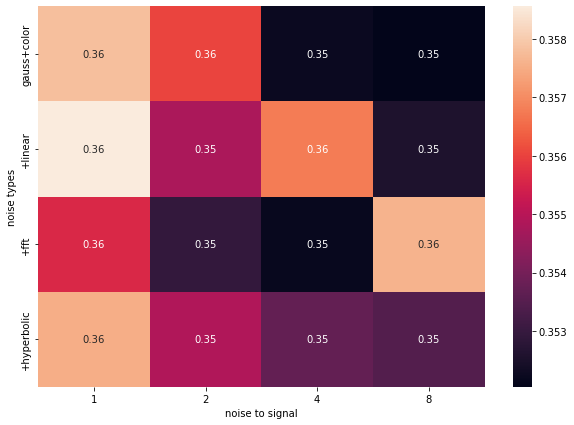

In [65]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(robustness, index = [i for i in ['gauss+color', '+linear', '+fft', '+hyperbolic']],
                  columns = [i for i in [1,2,4,8]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('noise to signal')
plt.ylabel('noise types')
plt.show()

In [ ]:
for noise_type in [0,1,2,3]:
    for noise_scale in [0.25,0.5,1.0,2.0]:
        model = build_model(model_type, problem)
        device = torch.device("cpu")
        model.to(device)
        weight_file = f'unet_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}'
        save_path = os.path.join(METADATA, weight_file + '.pkl')
        model.load_state_dict(torch.load(save_path))
        model.eval()
        print(weight_file)
        robustness = evaluate_robustness(model, metrics)
        np.save(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'),np.array(robustness))

In [30]:
noise_type = 3
noise_scale = 2.0
weight_file = f'unet_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}'
robustness = np.load(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'))

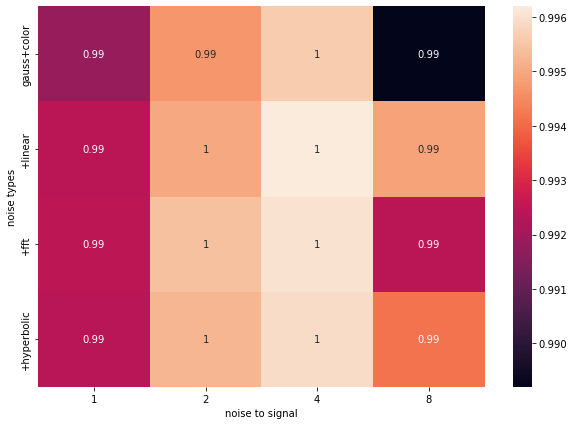

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(robustness, index = [i for i in ['gauss+color', '+linear', '+fft', '+hyperbolic']],
                  columns = [i for i in [1,2,4,8]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('noise to signal')
plt.ylabel('noise types')
plt.show()